In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import scipy
import os
from itertools import permutations
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from sklearn.linear_model import LinearRegression
import difflib
from moviepy.editor import *
from IPython.display import display, HTML
sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})
display(HTML("<style>.container { width:85% !important; }</style>"))

In [40]:
def rank_activity(grid):

    # Calculate rankings for each column, handling NaNs
    ranked_grid = np.zeros(grid.shape)
    ranked_grid[:] = np.nan

    for a in range(grid.shape[-1]):
        non_nan_indices = np.arange(len(region_ids))[np.isnan(grid[:, :, 0, a])[0]==False]
        for col in range(grid.shape[2]):
            col_data = grid[:, :, col, a] # n_cluster x n_rois
            # Check if the column has any NaN values
            col_indices_sorted = np.argsort(col_data, axis=0)[:, non_nan_indices]
            ranked_grid[:, non_nan_indices, col, a] = col_indices_sorted

    return ranked_grid

Inits

In [104]:
# full_data = pd.read_pickle('fully_labeled_traces_smoothedLabels_120423_nonznorm.pickle')
full_data = pd.read_pickle('E:\\fully_labeled_traces_smoothedLabels_031024.pickle')
# fuller_data = pd.read_pickle('C:\\Users\\Jorge\\Documents\\PythonScripts\\data4EI.pickle')

# region and indexing-related variables / functions
region_ids = ['PrL (E)', 'PrL (I)', 'vLS (E)', 'vLS (I)', 'POA (E)', 'POA (I)',
       'BNST (E)', 'BNST (I)', 'AH (E)', 'AH (I)', 'MeA (E)', 'MeA (I)',
       'VMH (E)', 'VMH (I)', 'PAG (E)', 'PAG (I)', 'PMv (E)', 'PMv (I)', 'LHb (E)', 'LHb (I)', 
       'PA (E)', 'PA (I)', 'NAc (DA)'] # populations
indices = {val: idx for idx, val in enumerate(region_ids)} # dictionary with IDs for remapping
clusters = np.unique(full_data['91R2_d1_balbc_t1']['unsupervised labels'])
print(clusters)
agg_animals = ['3095', '3096', '3097', '4013', '4014', '4015', '4016', '91R2', '30L', '30B', '30R2', '29L']
obs_animals = ['30R2', '29L']

[1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [105]:
### run ranking computation on aggressive experience
animals = np.concatenate([agg_animals, obs_animals])
all_activity = np.zeros((len(clusters), 23, 27, len(animals)))
all_activity[:] = np.nan

for a, animal in enumerate(animals):
    
    if a<=11:
        sessions = [x for x in list(full_data.keys()) if animal in x if '_balbc_' in x or '_mCD1_' in x]
    else:
        sessions = [x for x in list(full_data.keys()) if animal in x if '_obs_' in x or '_OBSmCD1_' in x]
        
    for s, session in enumerate(sessions):
        
        sample = full_data[session]
        activity_per_cluster = np.zeros((len(clusters), all_activity.shape[1]))

        for i, c in enumerate(clusters):
            idxs2extract = np.where(sample['unsupervised labels'] == c)[0]
            for r, roi in enumerate(sample.columns[:-3]):
                if len(idxs2extract)==0:
                    activity_per_cluster[i, r] = 0
                else:
                    activity_per_cluster[i, r] = np.nanmean(sample[roi].iloc[idxs2extract])

        # Perform ranking
        all_activity[:, :, s, a] = activity_per_cluster
        

In [106]:
# obtain rankings
agg_all_rankings = rank_activity(all_activity[:, :, :, :12])
obs_all_rankings = rank_activity(all_activity[:, :, :, 12:])


### Goal: to determine whether the mapping of activity of each region changes with experience
For each SESSION, we will create a vector containing a ranking of the activity of each region across each cluster. Broadly, this vector will be a 1d array 1-15. We will use kendall tau correlation for correlating ordinal data to establish differences in mapping across days. 

Linear mixed effects model breakdown: In this code, I have specified a mixed-effects model with three fixed effects predictors: session_trial, day_trial, and cum_trial. If the coefficient for any of these predictors is positve, it suggests that, on average, an increase in that predictor variable is associated with an increase in the dependent variable. 

In [107]:
def rank_all_activity(all_activity, a):
    bc1 = rank_activity(np.nanmean(all_activity[:, :, 0:3, a], axis=2))
    bc2 = rank_activity(np.nanmean(all_activity[:, :, 3:6, a], axis=2))
    bc8 = rank_activity(np.nanmean(all_activity[:, :, 21:24, a], axis=2))
    cd1 = rank_activity(np.nanmean(all_activity[:, :, 24:27, a], axis=2))
    return [bc1, bc2, bc8, cd1]

from scipy.stats import kendalltau
def compute_correlations(grid_condition1, grid_condition2, corr_func=np.corrcoef):
    # Initialize arrays to store correlations and residuals
    elementwise_correlations = np.zeros((22))
    elementwise_correlations[:] = np.nan
    pvals = np.zeros((22))
    pvals[:] = np.nan

    # Iterate through each column
    for col in range(grid_condition1.shape[1]):
        # Get the data for the current column
        col_data_condition1 = grid_condition1[:, col]
        col_data_condition2 = grid_condition2[:, col]

        # Check if either column contains NaN values
        if np.isnan(col_data_condition1).any() or np.isnan(col_data_condition2).any():
            continue
        else:
            # Calculate the correlation coefficient
#             correlation = corr_func(col_data_condition1, col_data_condition2)[0, 1] # if using np.corrcoef
            correlation = corr_func(col_data_condition1, col_data_condition2).correlation # if using np.corrcoef
            
            elementwise_correlations[col] = correlation

#             # Calculate the residuals
#             print(col_data_condition1 - correlation * col_data_condition2)
#             residuals[col] = col_data_condition1 - correlation * col_data_condition2
            
    return elementwise_correlations, residuals

Step 1. LM model -- we model kendall tau correlation (or separation of ordinal data) across days using time-related inputs: 1) the order of sessions, 2) the order of days, 3) the order of sessions within each day. The taus are calculated using as inputs the activity vector of the nth session and the nth-1 session.

In [108]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [109]:
# Save all R coefficients
sessions2exclude = -3
total_sessions = 27 + sessions2exclude - 1
rankings2move = agg_all_rankings[:, :, :sessions2exclude, :] # remove cd1
all_kendall_taus = np.zeros((total_sessions, len(region_ids), 12))
all_kendall_taus[:] = np.nan
for animal in np.arange(rankings2move.shape[-1]):
    for roi in np.arange(len(region_ids)):
        sample = rankings2move[:, roi, :, animal]
        for i in np.arange(sample.shape[1]-1):
            delta_r = kendalltau(sample[:,i], sample[:,i+1]).correlation
            all_kendall_taus[i,roi,animal] = delta_r
            

PrL (E)
Model did not converge.
PrL (I)
Model did not converge.
vLS (E)
Model did not converge.
vLS (I)
Model did not converge.
POA (E)
Model converged.
POA (I)
Model converged.
BNST (E)
Model did not converge.
BNST (I)
Model did not converge.
AH (E)
Model converged.
AH (I)
Model did not converge.
MeA (E)
Model did not converge.
MeA (I)
Model did not converge.
VMH (E)
Model did not converge.
VMH (I)
Model did not converge.
PAG (E)
Model converged.
PAG (I)
Model converged.
PMv (E)
Model converged.
PMv (I)
Model converged.
LHb (E)
Model converged.
LHb (I)
Model converged.
PA (E)
Model converged.
PA (I)
Model converged.
NAc (DA)
Model did not converge.


ValueError: Cannot predict random effects from singular covariance structure.

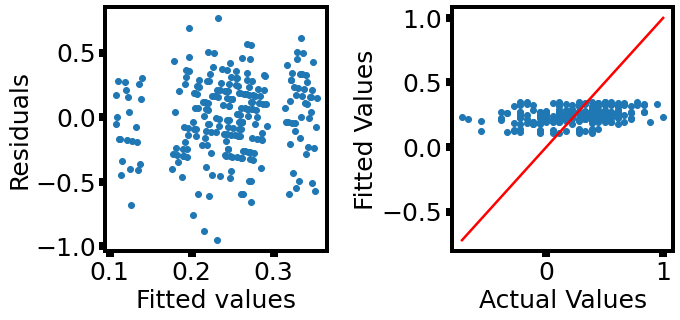

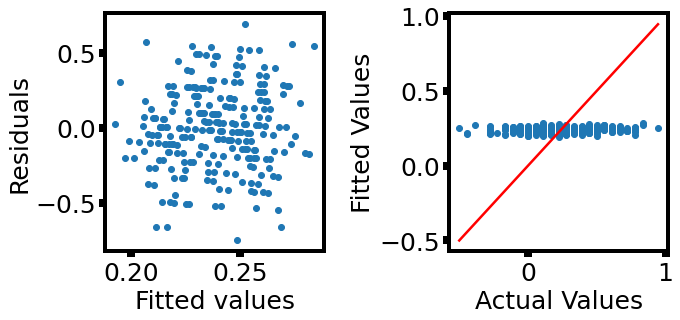

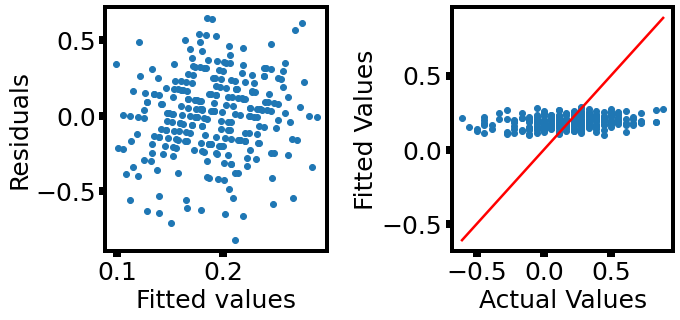

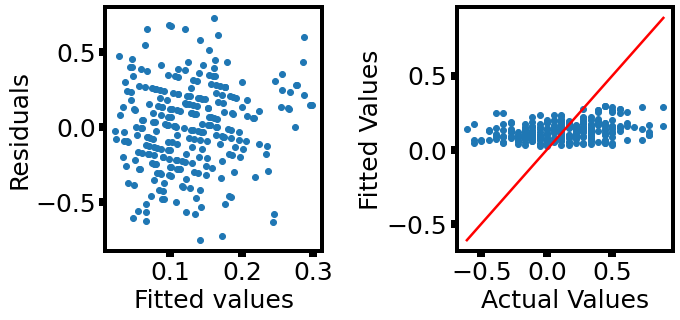

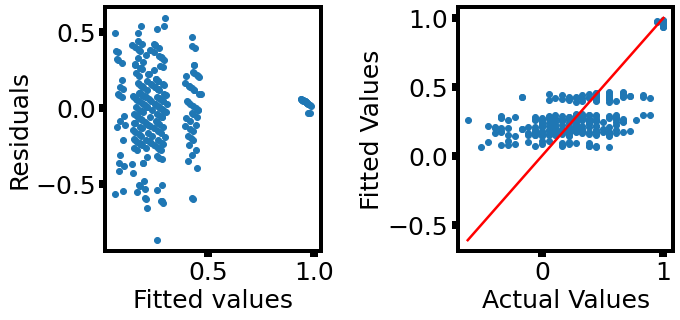

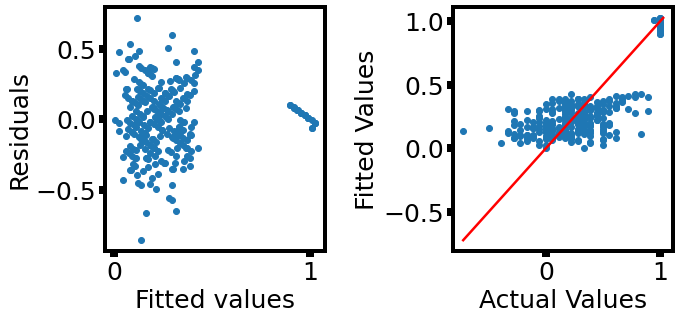

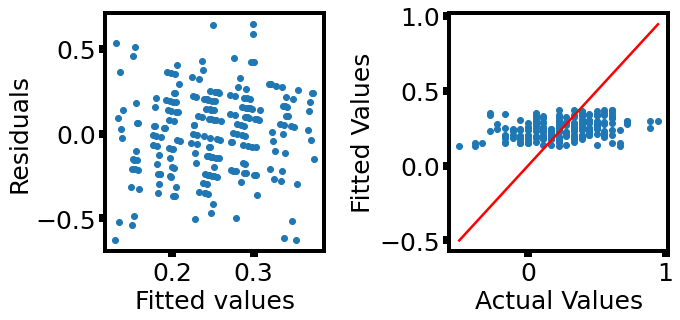

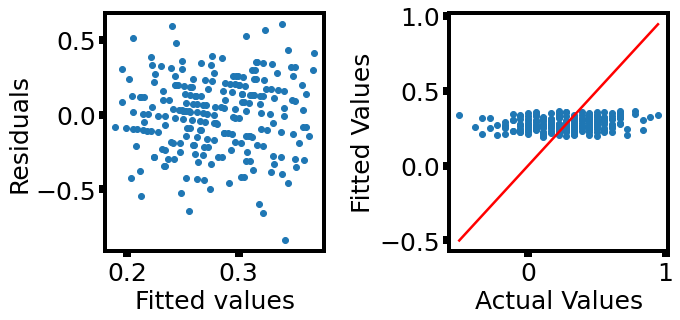

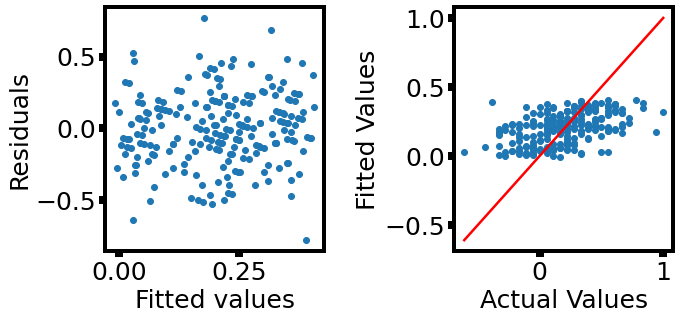

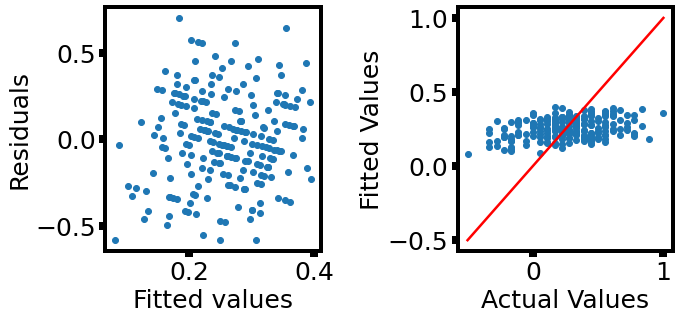

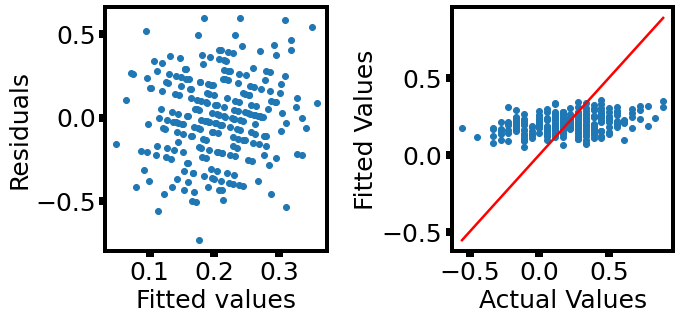

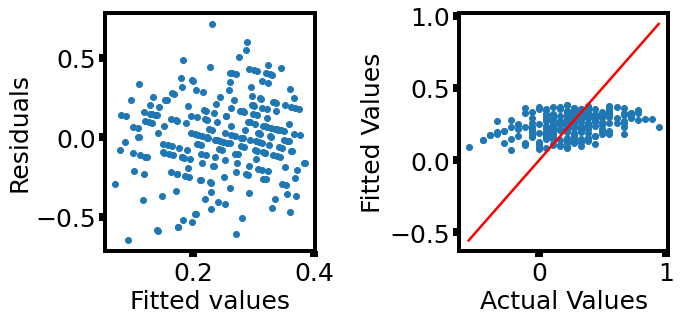

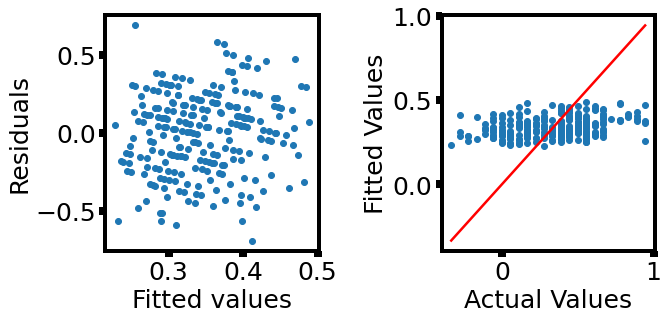

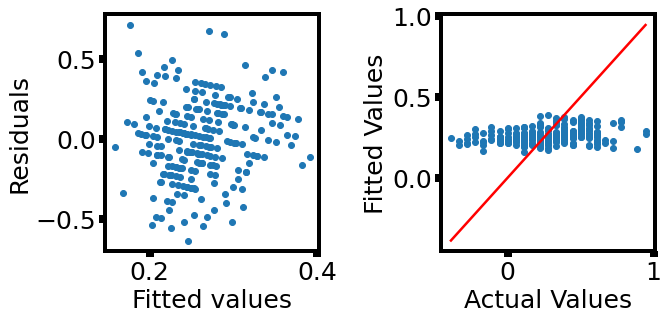

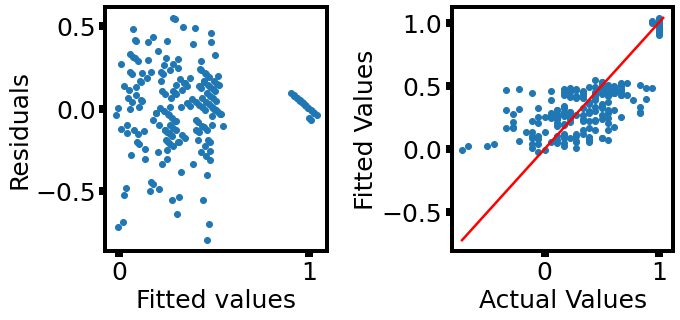

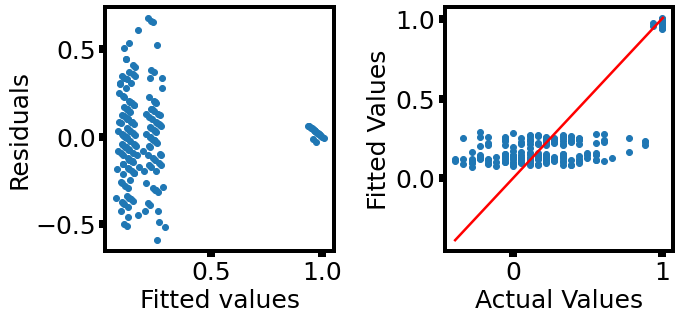

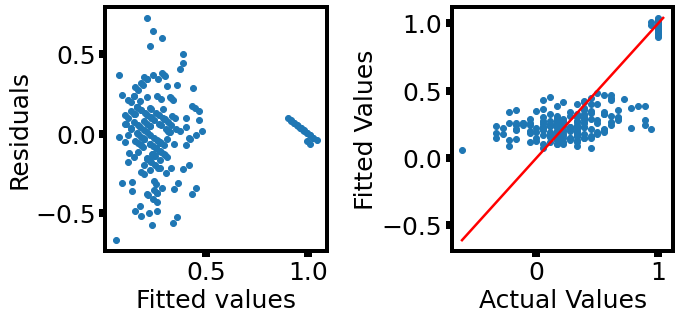

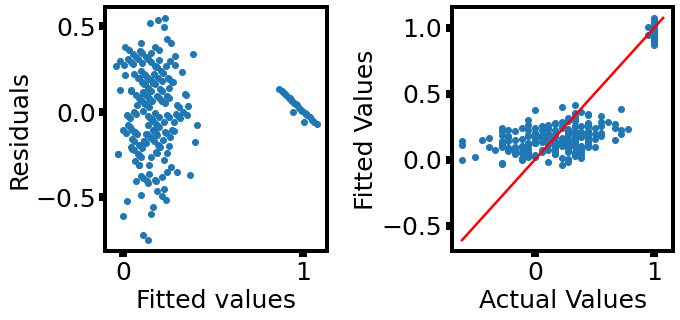

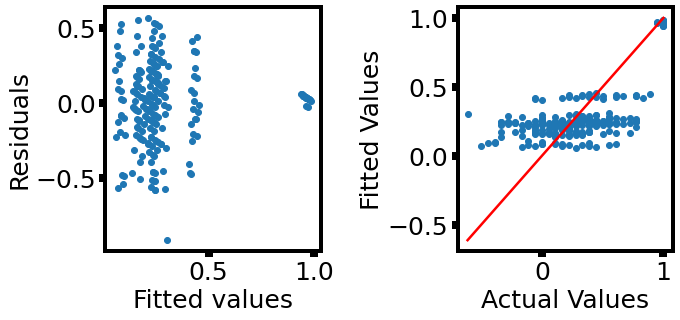

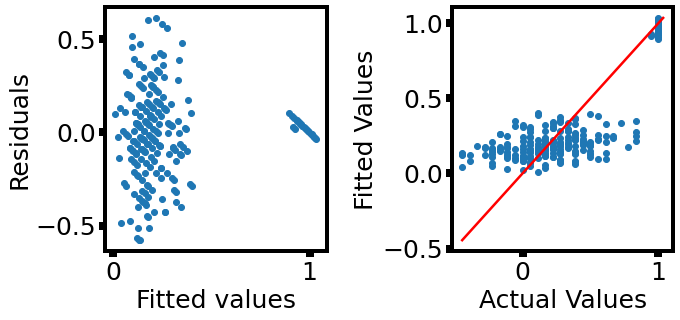

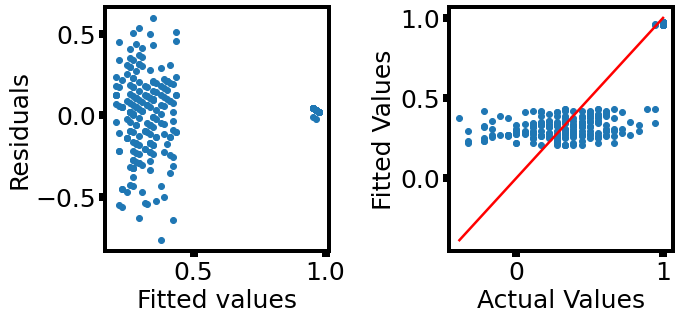

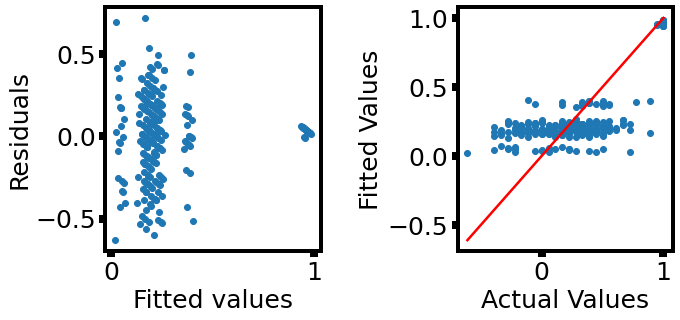

In [110]:
# Fit LM model to each region / animal / session
all_tables = {}

for r, roi in enumerate(region_ids):

    r_vals = np.concatenate(all_kendall_taus[:, r, :].T)
    trials = np.hstack([np.arange(total_sessions) for i in np.arange(12)]).astype(int)
    days = np.hstack([np.hstack([np.repeat(i, 3) for i in np.arange((total_sessions + 1)/3)])[1:] for i in np.arange(12)]).astype(int)
    sessions =np.hstack([np.concatenate([np.arange(2), np.hstack([np.arange(3) for i in np.arange(((total_sessions + 1)/3)-1)])]) for i in np.arange(12)]).astype(int)
    subjects = np.hstack([np.repeat(i, total_sessions) for i in np.arange(12)])
    table = pd.DataFrame(np.concatenate([trials.reshape(1,-1), days.reshape(1,-1), sessions.reshape(1,-1), subjects.reshape(1,-1), r_vals.reshape(1,-1)], axis=0).T)
    table = table.dropna(axis=0)
    all_tables[roi] = table
    
# do model fitting

def fit_model(df, predictors):

    results = {}

    # Create the formula
    formula = "dependent_variable ~ " + " + ".join(predictors)

    # Create a mixed linear model using smf.mixedlm
    mixed_lm = smf.mixedlm(
        formula=formula,
        groups="subject",
        data=df
    )

    # Fit the model
    mixed_lm_fit = mixed_lm.fit()
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings('error', category=ConvergenceWarning)
            results = mixed_lm.fit()
            print("Model converged.")
    except ConvergenceWarning:
        print("Model did not converge.")
    

    # Derive the predicted data
    predicted_data = mixed_lm_fit.predict()

    # Print the summary of the model
    # print(mixed_lm_fit.summary())
    
    return mixed_lm_fit, predicted_data

all_roi_results = []
plt.close()
for roi in region_ids:
    print(roi)
    sample = all_tables[roi]
    new_column_names = ['cum_trial', 'day_trial', 'session_trial', 'subject', 'dependent_variable']
    column_name_mapping = {old_column: new_column for old_column, new_column in zip(sample.columns, new_column_names)}
    sample = sample.rename(columns=column_name_mapping)
    sample = sample.dropna(axis=0)
    sample = sample.reset_index(drop=True)
    results,_ = fit_model(sample, predictors=['day_trial', 'session_trial'])

    residuals = results.resid
    fitted_values = results.fittedvalues
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(fitted_values, residuals)
    ax[0].set_xlabel('Fitted values')
    ax[0].set_ylabel('Residuals')

    # Create a scatter plot of the actual values against the fitted values
    fitted_values = results.fittedvalues
    ax[1].scatter(sample['dependent_variable'], fitted_values)
    ax[1].set_xlabel('Actual Values')
    ax[1].set_ylabel('Fitted Values')
    min_val = np.min([sample['dependent_variable'].min(), fitted_values.min()])
    max_val = np.max([sample['dependent_variable'].max(), fitted_values.max()])
    ax[1].plot([min_val, max_val], [min_val, max_val], color='red')
    plt.tight_layout()

    all_roi_results.append(results)

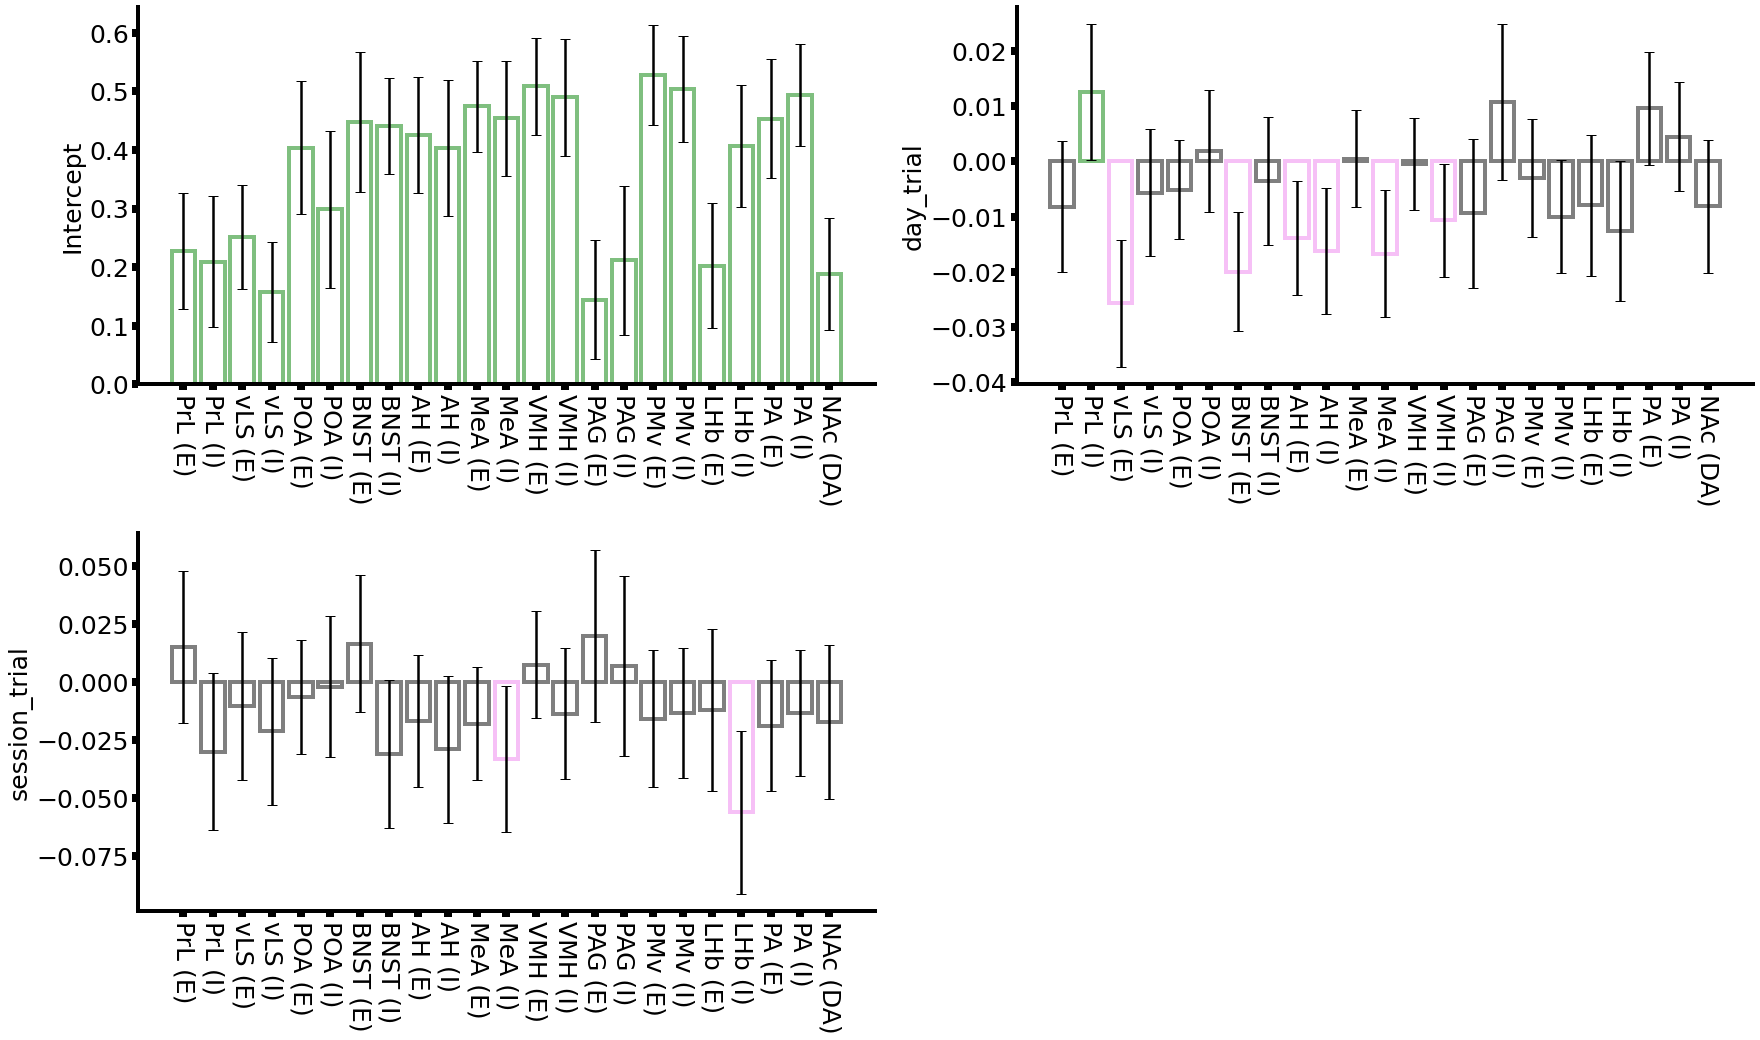

In [63]:
plt.close()
fig, ax = plt.subplots(2, 2, figsize=(25, 15))
ax = ax.ravel()
bars_added = [False] * len(ax)  # Track if bars were added to each subplot

for i, roi in enumerate(region_ids):
    for p, (param_name, param) in enumerate(zip(results.params.index[:-1], results.params[:-1])):
        # Extract result
        EI_result=all_roi_results[i].params[param_name]
        pval=all_roi_results[i].pvalues[p]
        # multiple comparisons
        
        if EI_result > 0 and pval < 0.05:
            color='green'
        elif EI_result < 0 and pval < 0.05:
            color='violet'
        elif pval > 0.05:
            color='black'
        # Extract CI
        yerr=(all_roi_results[i].conf_int().iloc[p, 1]-all_roi_results[i].conf_int().iloc[p, 0]) * .5

        if not np.isnan(EI_result):  # Only add bar if result is not NaN
            ax[p].bar(i, EI_result, color='white', alpha=0.5, edgecolor=color, linewidth=4, yerr=yerr, capsize=5)
            bars_added[p] = True  # Mark that a bar was added to this subplot

        if bars_added[p]:  # Only set labels if bars were added to this subplot
            ax[p].set_xticks(np.arange(len(region_ids)))
            ax[p].set_xticklabels(region_ids, rotation=270)
            ax[p].set_ylabel(param_name)
            sns.despine()

for p, added in enumerate(bars_added):
    if not added:  # If no bars were added to this subplot, remove its axis
        ax[p].axis('off')

plt.tight_layout()
# plt.savefig('./DSPAN_figs/aggro_activity.svg', dpi=300)

Step 4. Compute changes in EI across map

In [320]:
def compute_EI(grid, n_clusters, n_animals=12):

    EI_grid = np.zeros((n_clusters, 10, grid.shape[2], n_animals))
    EI_grid[:] = np.nan

    for a in range(grid.shape[-1]):
        for i, idx in enumerate([0, 2, 4, 6, 8, 10, 12, 15, 17, 19]): # E indices
            exc = grid[n_clusters, idx, :, a] # if clusters are selected monotonically
            inh = grid[n_clusters, idx+1, :, a] # if clusters are selected monotonically
            EI_grid[:, i, :, a] = (exc-inh) / np.nanmedian(exc+inh)

    return EI_grid

def euclidean_distance(vector1, vector2):
    """
    Calculate the Euclidean distance between two vectors.

    Parameters:
    - vector1: NumPy array or list, the first vector.
    - vector2: NumPy array or list, the second vector.

    Returns:
    - distance: Euclidean distance between the two vectors.
    """
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)
    distance = np.linalg.norm(vector1 - vector2)
    return distance

def cosine_similarity(vector1, vector2):
    """
    Calculate the cosine similarity between two vectors.

    Parameters:
    - vector1: NumPy array or list, the first vector.
    - vector2: NumPy array or list, the second vector.

    Returns:
    - similarity: Cosine similarity between the two vectors.
    """
    # Convert the input vectors to NumPy arrays
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)

    # Calculate the dot product of the two vectors
    dot_product = np.dot(vector1, vector2)

    # Calculate the magnitudes (Euclidean norms) of the vectors
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)

    # Calculate the cosine similarity
    similarity = dot_product / (magnitude1 * magnitude2)

    return similarity


def vector_difference(vector1, vector2):
    """
    Calculate the vector difference between two vectors.

    Parameters:
    - vector1: NumPy array or list, the first vector.
    - vector2: NumPy array or list, the second vector.

    Returns:
    - difference: Vector difference (vector1 - vector2).
    """
    # Convert the input vectors to NumPy arrays
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)

    # Calculate the vector difference
    difference = vector1 - vector2

    return np.mean(difference)

dist_func = vector_difference

# For computing EI indices
n_clusters = [0, 1, 2, 4]
total_sessions = 27

# AGG
# n_animals = 12
# EI_data = np.zeros((len(n_clusters), 10, 27, n_animals)) # modify the animals here
# EI_data[:, :, :,:] = compute_EI(all_activity[:, :, :, :12], n_clusters=len(n_clusters), n_animals=n_animals) 
# OBS
n_animals = 2
EI_data = np.zeros((len(n_clusters), 10, 27, n_animals)) # modify the animals here
EI_data[:, :, :,:] = compute_EI(all_activity[:, :, :, -n_animals:], n_clusters=len(n_clusters), n_animals=n_animals) 

# For saving
all_dists = np.zeros((total_sessions, 10, n_animals))
all_dists[:] = np.nan

for animal in np.arange(EI_data.shape[-1]):
    for roi in np.arange(10):
        sample = EI_data[:, roi, :, animal]
        for real_i, i in enumerate(np.arange(1, sample.shape[1])):
            dist = dist_func(sample[:,i], sample[:,0])
            all_dists[real_i,roi,animal] = dist

PFC
Model converged.
vLS
Model converged.
POA
Model converged.
BNST
Model converged.
AH
Model converged.
MeA
Model converged.
VMH
Model converged.
PMv
Model did not converge.
LHb
Model converged.
PA
Model converged.


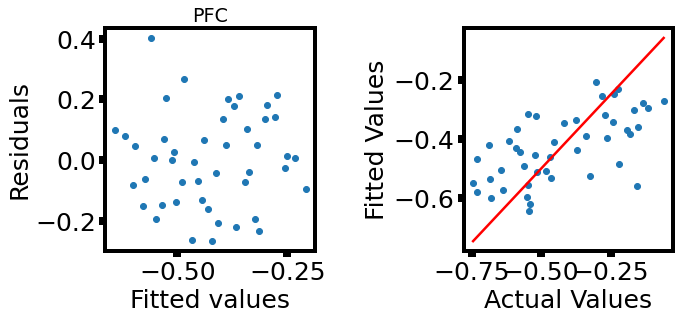

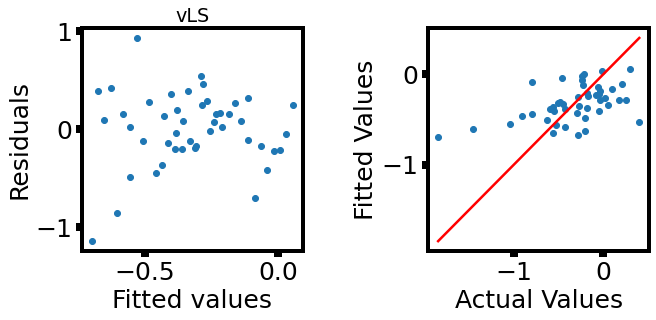

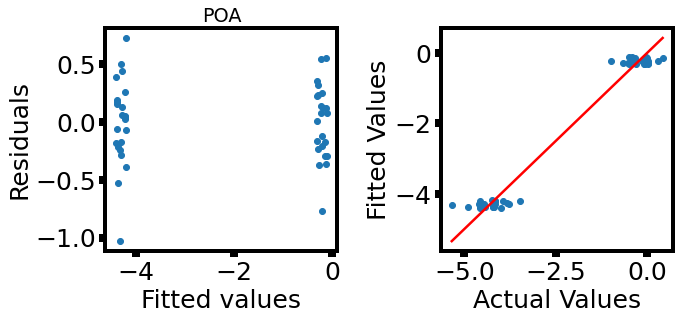

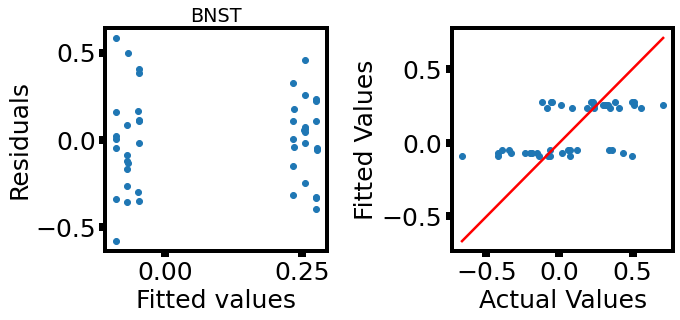

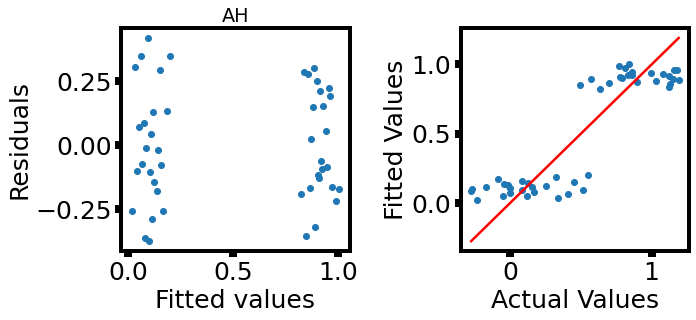

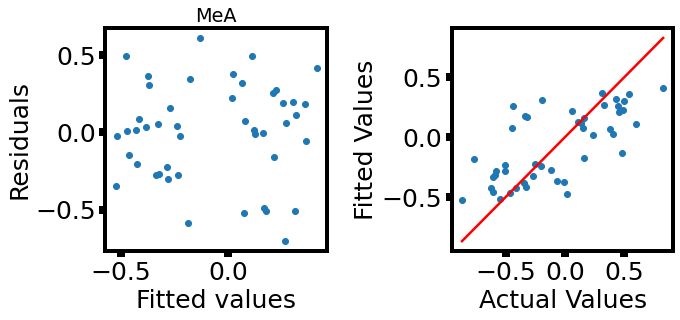

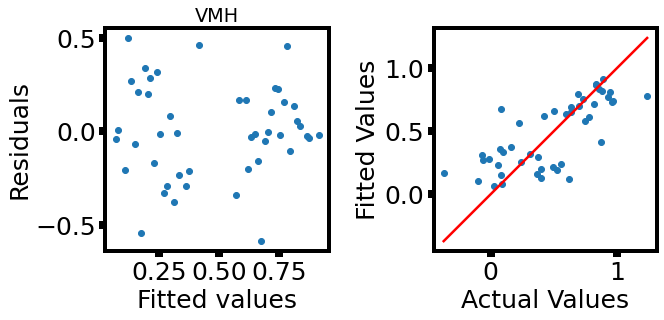

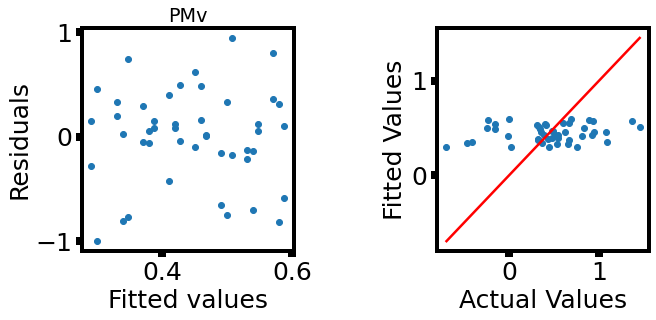

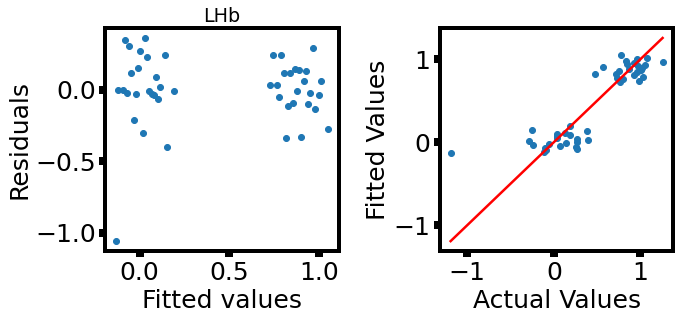

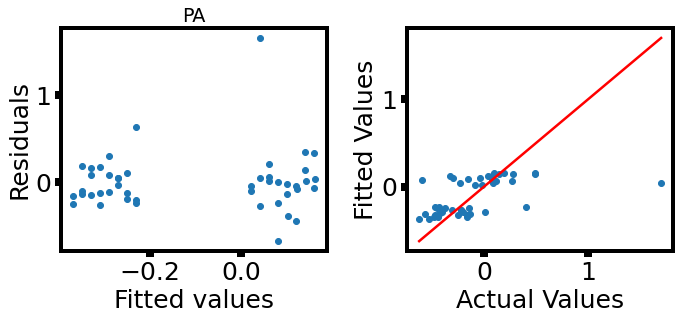

In [342]:
# Gather tables

all_tables = {}
EI_regions = ['PFC', 'vLS', 'POA', 'BNST', 'AH', 'MeA', 'VMH', 'PMv', 'LHb', 'PA']
animals2exclude = -12 # -2 for agg, -12 for obs
sessions2exclude = [1, 24] # [1, 27] for agg, [1, 24] for obs
all_tables = []
for roi in EI_regions:
    table = pd.DataFrame(columns=['cross_day', 'cross_session', 'within_day', 'subject', 'dependent_variable'])
    for animal in np.arange((len(np.concatenate([agg_animals, obs_animals]))+animals2exclude)):
        sample = all_dists[sessions2exclude[0]:sessions2exclude[1], EI_regions.index(roi), animal]
        cross_day_info = np.repeat(np.arange(9), 3)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        within_day_info = np.tile(np.arange(3), 9)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        session_info = np.arange(27)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        subject_info = np.repeat(animal, 27)[sessions2exclude[0]:sessions2exclude[1]]
        table = pd.concat([table, pd.DataFrame({'cross_day': cross_day_info, 'cross_session': session_info, 'within_day': within_day_info, 'subject': subject_info, 'dependent_variable': sample})])
    all_tables.append(table)
    
# do model fitting

all_roi_results = []
plt.close()
for t, roi in enumerate(EI_regions):
    print(roi)
    table = all_tables[t]
    table = table.dropna(axis=0)
    table = table.reset_index(drop=True)
    results, predicted_data = fit_model(table, predictors=['cross_day', 'within_day'])
    # Plot residuals
    residuals = results.resid
    fitted_values = results.fittedvalues
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_title(roi)
    ax[0].scatter(fitted_values, residuals)
    ax[0].set_xlabel('Fitted values')
    ax[0].set_ylabel('Residuals')

    # Create a scatter plot of the actual values against the fitted values
    fitted_values = results.fittedvalues
    ax[1].scatter(table['dependent_variable'], fitted_values)
    ax[1].set_xlabel('Actual Values')
    ax[1].set_ylabel('Fitted Values')
    min_val = np.min([table['dependent_variable'].min(), fitted_values.min()])
    max_val = np.max([table['dependent_variable'].max(), fitted_values.max()])
    ax[1].plot([min_val, max_val], [min_val, max_val], color='red')
    plt.tight_layout()
    # plt.savefig('C:\\Users\\Jorge\\Desktop\\DSPAN_figs\\fit.svg', dpi=300, bbox_inches='tight')

    all_roi_results.append(results)

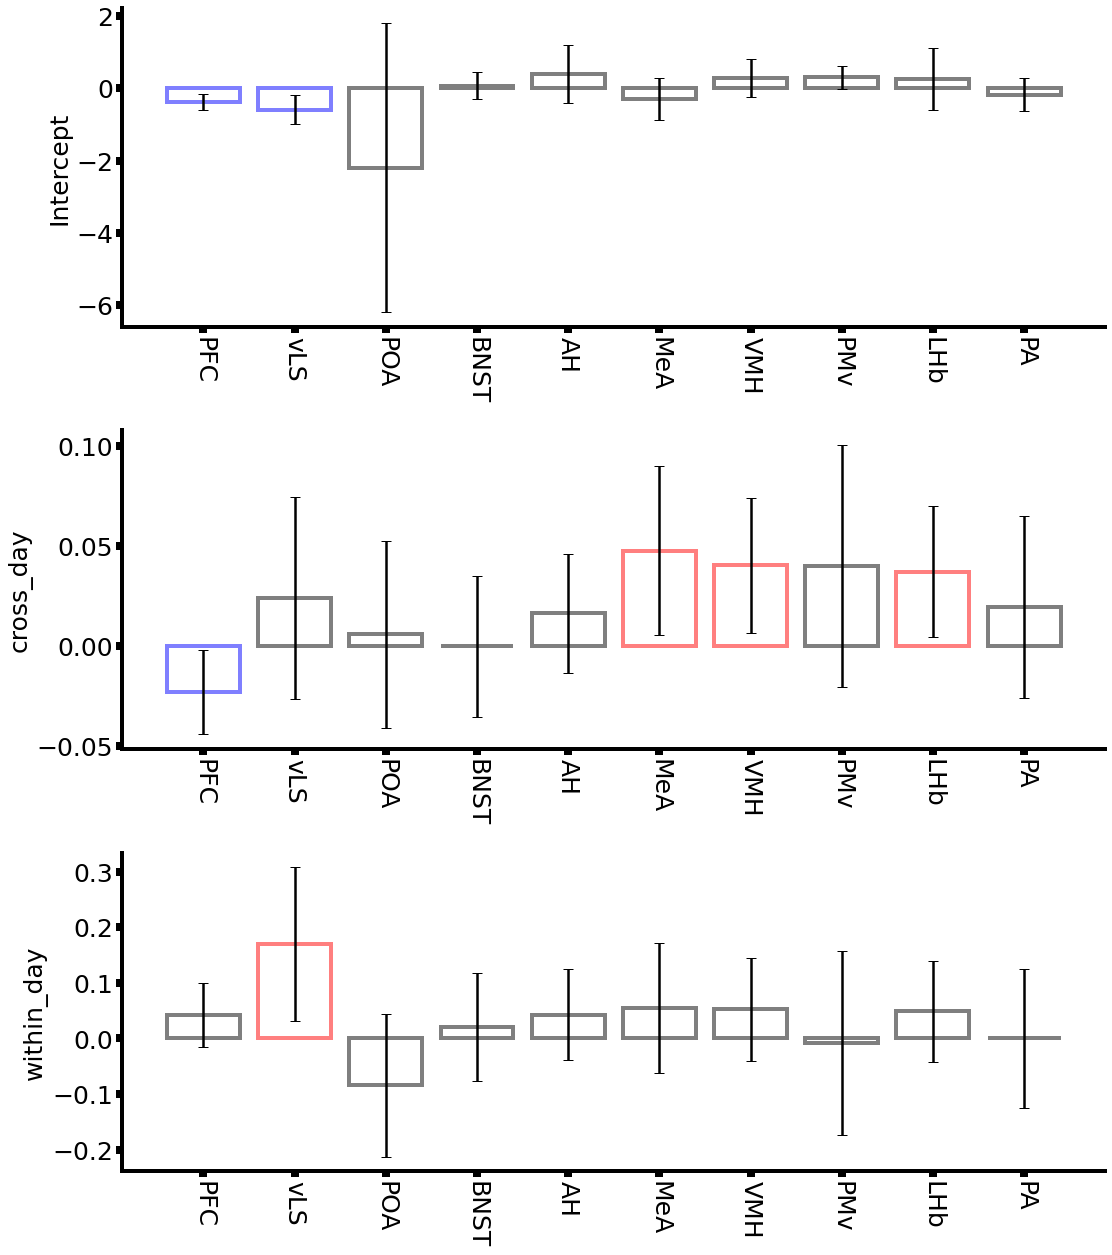

In [343]:
plt.close()
fig, ax = plt.subplots(3, 1, figsize=(16, 18))
ax = ax.ravel()
bars_added = [False] * len(ax)  # Track if bars were added to each subplot

for i, roi in enumerate(EI_regions):
    for p, (param_name, param) in enumerate(zip(results.params.index[:-1], results.params[:-1])):
        # Extract result
        EI_result=all_roi_results[i].params[param_name]
        pval=all_roi_results[i].pvalues[p]
        # multiple comparisons
        
        if EI_result > 0 and pval < 0.05:
            color='red'
        elif EI_result < 0 and pval < 0.05:
            color='blue'
        elif pval > 0.05:
            color='black'
        # Extract CI
        yerr=(all_roi_results[i].conf_int().iloc[p, 1]-all_roi_results[i].conf_int().iloc[p, 0]) * .5

        if not np.isnan(EI_result):  # Only add bar if result is not NaN
            ax[p].bar(i, EI_result, color='white', alpha=0.5, edgecolor=color, linewidth=4, yerr=yerr, capsize=5)
            bars_added[p] = True  # Mark that a bar was added to this subplot

        if bars_added[p]:  # Only set labels if bars were added to this subplot
            ax[p].set_xticks(np.arange(len(EI_regions)))
            ax[p].set_xticklabels(EI_regions, rotation=270)
            ax[p].set_ylabel(param_name)
            sns.despine()
            # if p==0:
            #     ax[p].set_ylim(bottom=0, top=0.5)
            # if p==1:
            #     ax[p].set_ylim(bottom=-0.1, top=0.1)
            # if p==2:
            #     ax[p].set_ylim(bottom=-0.1, top=0.1)

for p, added in enumerate(bars_added):
    if not added:  # If no bars were added to this subplot, remove its axis
        ax[p].axis('off')

plt.tight_layout()
# plt.savefig('./DSPAN_figs/aggro_activity.svg', dpi=300)

[0.1959 0.2891 0.6734 0.1592 0.2709 0.9203 0.3581 0.3026 0.0164 0.995 ]
[0.8051 0.0268 0.9911 0.0304 0.0191 0.1947 0.0276 0.2823 0.3546 0.3949]


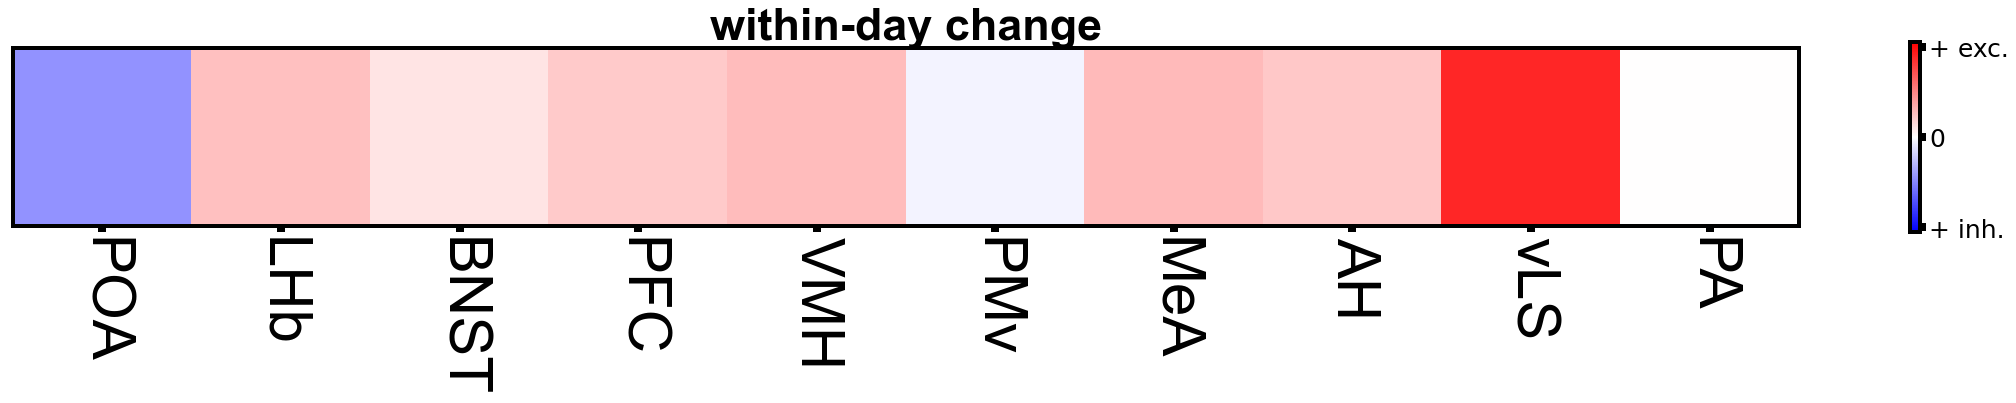

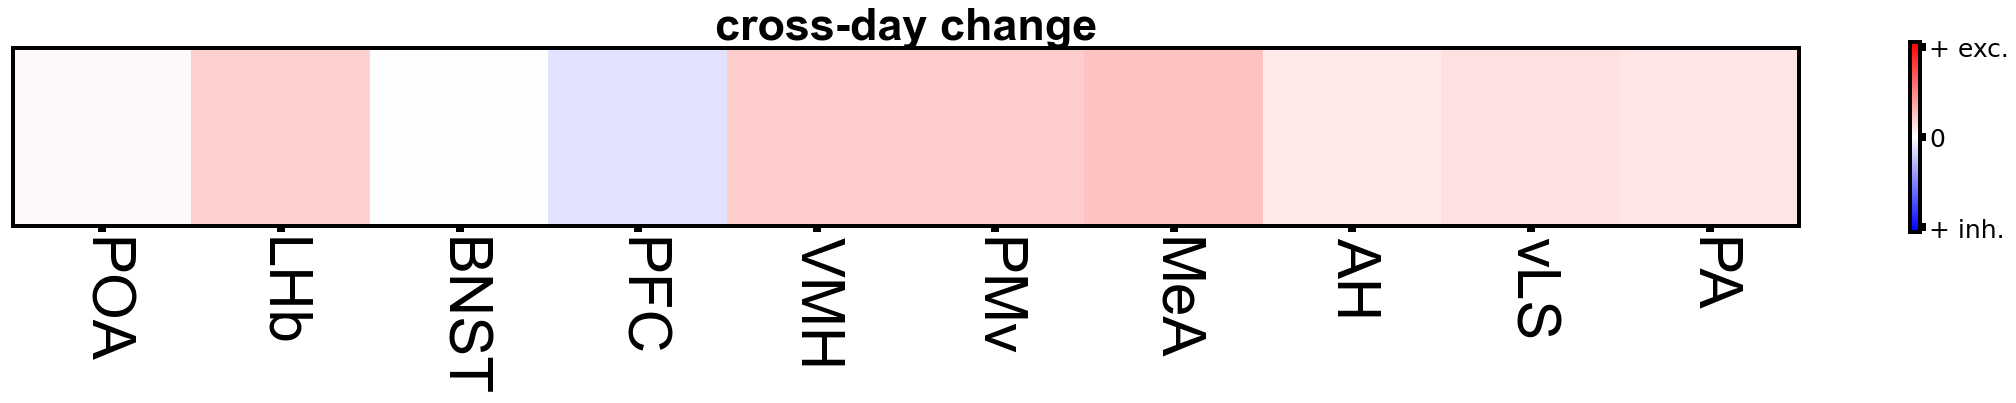

In [347]:
from matplotlib import colors
np.set_printoptions(precision=4, suppress=True)

n = len(EI_regions)
cmap = 'bwr'

# within-day change

weights = np.asarray([all_roi_results[i].params['within_day'] for i in np.arange(n)])
# ascending_idx = np.argsort(weights)
weights_sorted = weights[ascending_idx]
pval= 2
pvalues = np.asarray([all_roi_results[i].pvalues[pval] for i in np.arange(n)])[ascending_idx]
print(pvalues)
# weights_sorted[pvalues > 0.05] = 0
vmin = -0.2
vmax = 0.2
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
plt.figure(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin+0.01, 0, vmax-0.01])
cbar.set_ticklabels(['+ inh.', 0, '+ exc.'])
plt.title('within-day change', fontfamily='Arial', weight='bold', fontsize=45)
plt.xticks(np.arange(n), np.array(EI_regions)[ascending_idx], rotation=270, fontfamily='Arial', fontsize=60);
plt.yticks([])
plt.gca().invert_yaxis()
# plt.title('nonlinear change', fontfamily='Arial', weight='bold', fontsize=45)
plt.savefig('C:\\Users\\Jorge\\Desktop\\DSPAN_figs\\linear_mixed_model_within-day_obs.svg', dpi=600, bbox_inches='tight')

# cumul changes

weights = np.asarray([all_roi_results[i].params['cross_day'] for i in np.arange(n)])
# ascending_idx = np.argsort(weights)
weights_sorted = weights[ascending_idx]
pval = 1
pvalues = np.asarray([all_roi_results[i].pvalues[pval] for i in np.arange(n)])[ascending_idx]
print(pvalues)
# weights_sorted[pvalues > 0.05] = 0
vmin = -0.2
vmax = 0.2
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
plt.figure(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin+0.01, 0, vmax-0.01])
cbar.set_ticklabels(['+ inh.', 0, '+ exc.'])
plt.title('cross-attack change', fontfamily='Arial', weight='bold', fontsize=45)
plt.xticks(np.arange(n), np.array(EI_regions)[ascending_idx], rotation=270, fontfamily='Arial', fontsize=60);
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('cross-day change', fontfamily='Arial', weight='bold', fontsize=45)
plt.savefig('C:\\Users\\Jorge\\Desktop\\DSPAN_figs\\linear_mixed_model_cross-day_obs.svg', dpi=600, bbox_inches='tight')



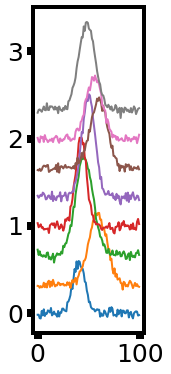

In [266]:
signals = []
for _ in range(8):
    # Generate a random amplitude, standard deviation, and peak shift
    amplitude = np.random.uniform(0.5, 1.5)
    std_dev = np.random.uniform(5, 10)  # Reduced range for standard deviation
    peak_shift = np.random.uniform(-10, 10)  # Shift peak to left or right

    # Generate the signal
    signal = amplitude * np.exp(-0.5 * ((np.arange(num_points) - (center + peak_shift)) / std_dev) ** 2)

    # Add noise to the signal
    noise = np.random.normal(0, 0.03, num_points)  # Noise with mean 0 and standard deviation 0.1
    signal += noise

    # Add the signal to the list
    signals.append(signal)

# Plot the signals
plt.figure(figsize=(2, 6))
for i, signal in enumerate(signals):
    plt.plot(signal+(i/3), label=f'Signal {i+1}', linewidth=2)
    # plt.axis('off')
# plt.savefig('C://Users//Jorge//Desktop//DSPAN_figs//signals.svg', dpi=300, bbox_inches='tight')
# plt.legend()
# plt.show()

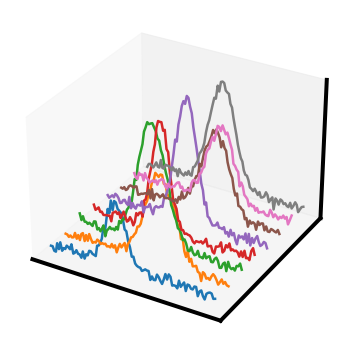

In [289]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(111, projection='3d')

x = np.arange(num_points)

for i, signal in enumerate(signals):
    y = np.full(num_points, i)  # Create a 'y' array filled with the current index
    ax.plot(x, y, signal)
# plt.axis('off')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.plot([50, 50], [0, num_signals-1], [0, 0], color='red', linewidth=20)
plt.savefig('C://Users//Jorge//Desktop//DSPAN_figs//signals.svg', dpi=300, bbox_inches='tight')